In [2]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from rapidfuzz import process, fuzz


In [3]:
df = pd.read_csv("Amazon.csv")
df.head()

,Unnamed: 0,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,0,Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...,NaN,99.99,5,"Gracias, excelente.",0.0
1,1,Samsung Galaxy S5 G900A 16GB Unlocked GSM 4G L...,Samsung,219.00,1,"I got the phone in good condition, but its car...",2.0
2,2,Apple iPhone 5C 16GB White - Unlocked Cell Phones,Apple,135.00,5,Great phone No problems works perfect now for ...,1.0
3,3,"Motorola Moto X - 16GB, Unlocked Phone - US Wa...",Motorola,89.99,5,"great price with the discount, white is a nice...",0.0
4,4,BLU Tank II T193 Unlocked GSM Dual-SIM Cell Ph...,BLU,18.93,5,A1,0.0


In [4]:
print("num of row, col:",df.shape)

print("col names:",df.columns)#need adjust first col name

print(df.info())

df.describe()

num of row, col: (124152, 7)
col names: Index(['Unnamed: 0', 'Product Name', 'Brand Name', 'Price', 'Rating',
       'Reviews', 'Review Votes'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124152 entries, 0 to 124151
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    124152 non-null  int64  
 1   Product Name  124152 non-null  object 
 2   Brand Name    104462 non-null  object 
 3   Price         122345 non-null  float64
 4   Rating        124152 non-null  int64  
 5   Reviews       124132 non-null  object 
 6   Review Votes  120436 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 6.6+ MB
None


,Unnamed: 0,Price,Rating,Review Votes
count,124152.000000,122345.000000,124152.000000,120436.000000
mean,62075.500000,226.884201,3.819576,1.516092
std,35839.739647,272.405948,1.548216,9.142258
min,0.000000,1.730000,1.000000,0.000000
25%,31037.750000,79.990000,3.000000,0.000000
50%,62075.500000,144.710000,5.000000,0.000000
75%,93113.250000,273.780000,5.000000,1.000000
max,124151.000000,2566.000000,5.000000,524.000000


In [5]:
df.drop(columns = ['Unnamed: 0'],inplace = True)

In [6]:
df.isnull().sum()

Product Name        0
Brand Name      19690
Price            1807
Rating              0
Reviews            20
Review Votes     3716
dtype: int64

We're using this dataset for nlp, so drop product without reviews.

In [7]:
df_reviews = df.dropna(subset=['Reviews'])
df_reviews.isnull().sum()

Product Name        0
Brand Name      19687
Price            1806
Rating              0
Reviews             0
Review Votes     3716
dtype: int64

I found that some product do not have brand name, but most brand name is the first word in the product name. I will add brand name for them and then normalized all brand name.  

In [8]:
df_reviews['Brand Name'] = df_reviews['Brand Name'].astype(str).str.lower().str.strip()

def extract_brand(product_name):
    return product_name.split()[0].lower().strip() if isinstance(product_name, str) else ''

df_reviews.loc[df_reviews['Brand Name'].isin(['nan', '']), 'Brand Name'] = df_reviews.loc[df_reviews['Brand Name'].isin(['nan', '']), 'Product Name'].apply(extract_brand)
df_reviews.isnull().sum()


/var/folders/bd/sjwzf5qj237dq18gq9s2d5b80000gn/T/ipykernel_14371/4053582990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['Brand Name'] = df_reviews['Brand Name'].astype(str).str.lower().str.strip()


Product Name       0
Brand Name         0
Price           1806
Rating             0
Reviews            0
Review Votes    3716
dtype: int64

/var/folders/bd/sjwzf5qj237dq18gq9s2d5b80000gn/T/ipykernel_14371/3686005365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['Brand Name'] = df_reviews['Brand Name'].astype(str).str.lower()


Brand Name
samsung                     24921
apple                       22917
blu                         19166
lg                           8489
blackberry                   6041
                            ...  
5.5"                            1
jinhaihuahui                    1
sdeals                          1
ut starcom                      1
marozi international ltd        1
Name: count, Length: 340, dtype: int64


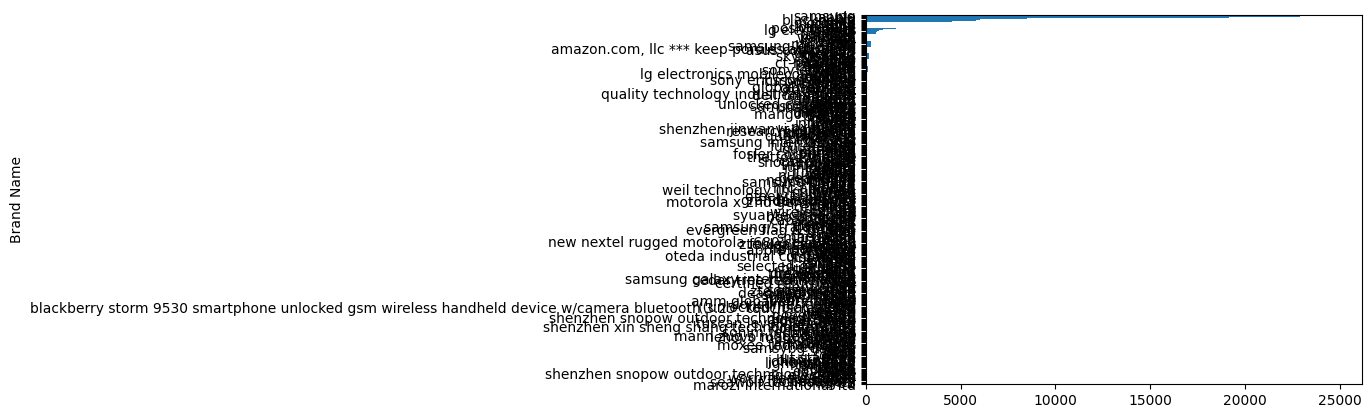

In [9]:
df_reviews['Brand Name'] = df_reviews['Brand Name'].astype(str).str.lower()
brand_count = df_reviews['Brand Name'].value_counts()
brand_count.sort_values().plot(kind='barh')
print(brand_count)

This plot shows extremely skewed brand distributions and unstandarlized brand names.

In [10]:
brand_review_counts = df_reviews.groupby('Brand Name')['Reviews'].count()
brand_review_counts.sort_values(ascending=False).head(15)

Brand Name
samsung           24921
apple             22917
blu               19166
lg                 8489
blackberry         6041
nokia              5813
motorola           4542
cnpgd              4080
htc                4037
sony               3385
otterbox           2826
posh mobile        1972
huawei             1576
lg electronics      907
asus                718
Name: Reviews, dtype: int64

<Axes: ylabel='Brand Name'>

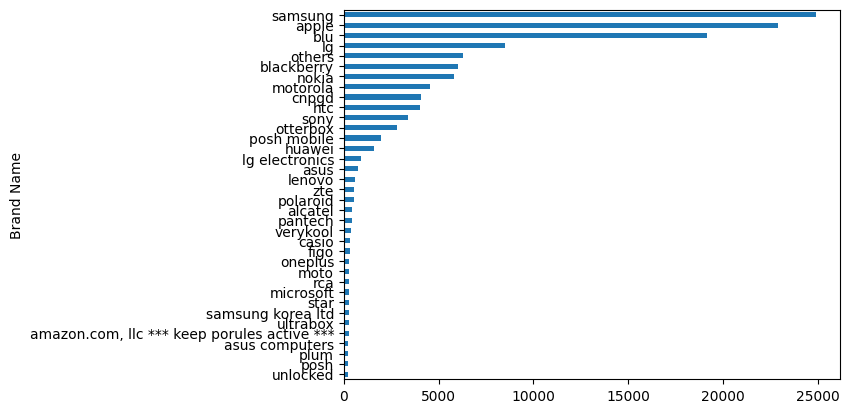

In [11]:
sort_brand = df_reviews.copy()

rare_brands = brand_review_counts[brand_review_counts < 200].index
sort_brand.loc[sort_brand['Brand Name'].isin(rare_brands), 'Brand Name'] = 'others'

unique_brands = sort_brand['Brand Name'].unique().tolist()

def unify_brand_name(brand, all_brands, threshold=80):
    match, score, _ = process.extractOne(brand, all_brands)
    if score >= threshold:
        return match
    else:
        return brand
    
sort_brand['Brand Name'] = sort_brand['Brand Name'].apply(lambda x: unify_brand_name(x, unique_brands))

brand_count = sort_brand['Brand Name'].value_counts()
brand_count.sort_values().plot(kind='barh')

From the plot we can find out the first duplicate in brand name is No.14 lg electronics, so collecting the first 13 known brands as brand list.

In [12]:
#top 13 brands
top_13_brands = brand_review_counts.sort_values(ascending=False).head(13).index.tolist()

top_13_brands

['samsung',
 'apple',
 'blu',
 'lg',
 'blackberry',
 'nokia',
 'motorola',
 'cnpgd',
 'htc',
 'sony',
 'otterbox',
 'posh mobile',
 'huawei']

if the brand name contains words which in known brand list, we classify them into the known brand. 

In [13]:
def map_to_known_brand(brand, known_brands):
    for kb in known_brands:
        if kb in brand:
            return kb 
    return brand

In [14]:
df_cleaned = df_reviews.copy()
df_cleaned['Brand Name'] = df_cleaned['Brand Name'].apply(
    lambda x: map_to_known_brand(x, top_13_brands)
)
df_cleaned.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...,apple,99.99,5,"Gracias, excelente.",0.0
1,Samsung Galaxy S5 G900A 16GB Unlocked GSM 4G L...,samsung,219.00,1,"I got the phone in good condition, but its car...",2.0
2,Apple iPhone 5C 16GB White - Unlocked Cell Phones,apple,135.00,5,Great phone No problems works perfect now for ...,1.0
3,"Motorola Moto X - 16GB, Unlocked Phone - US Wa...",motorola,89.99,5,"great price with the discount, white is a nice...",0.0
4,BLU Tank II T193 Unlocked GSM Dual-SIM Cell Ph...,blu,18.93,5,A1,0.0
5,Sony Xperia Z3 Compact D5833 Unlocked Smartpho...,sony,499.99,1,"The cellphone worked just fine for a while, bu...",6.0
6,Honor 8 Dual Camera Unlocked Phone 64GB - Sunr...,honor,449.99,3,Although the phone has many positive qualities...,8.0
7,BlackBerry Curve 9300 3G Unlocked GSM Smartpho...,blackberry,59.99,5,bueno gracia,0.0
8,"Blackberry Curve 8310 Unlocked Phone with GPS,...",blackberry,14.87,1,"A total waste of time. Folks, learn the hard l...",0.0
9,"Nokia E66 Unlocked Phone with 3.2 MP Camera, I...",nokia,269.10,4,Good quality,0.0


After nomarlized brand name

for business understanding their market share and reputation, group by brand is the best way for analyzing. 

In [15]:

def clean_and_unify_brands(df, brand_col='Brand Name', review_col='Reviews', rare_threshold=30, fuzzy_threshold=80):

    df_updated = df.copy()

    brand_review_counts = df_updated.groupby(brand_col, as_index=False)[review_col].count()
    rare_brands = brand_review_counts.loc[brand_review_counts[review_col] < rare_threshold, brand_col].tolist()
    df_updated.loc[df_updated[brand_col].isin(rare_brands), brand_col] = 'others'

    unique_brands = df_updated[brand_col].unique().tolist()
    
    def unify_brand_name(brand, all_brands, threshold):
        match, score, _ = process.extractOne(brand, all_brands)
        return match if score >= threshold else brand
    
    df_updated[brand_col] = df_updated[brand_col].apply(lambda x: unify_brand_name(x, unique_brands, fuzzy_threshold))
    
    return df_updated

df_final = clean_and_unify_brands(df_cleaned, brand_col='Brand Name', review_col='Reviews', rare_threshold=500, fuzzy_threshold=80)

df_final.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Apple iPhone 4s 8GB Unlocked Smartphone w/ 8MP...,apple,99.99,5,"Gracias, excelente.",0.0
1,Samsung Galaxy S5 G900A 16GB Unlocked GSM 4G L...,samsung,219.00,1,"I got the phone in good condition, but its car...",2.0
2,Apple iPhone 5C 16GB White - Unlocked Cell Phones,apple,135.00,5,Great phone No problems works perfect now for ...,1.0
3,"Motorola Moto X - 16GB, Unlocked Phone - US Wa...",motorola,89.99,5,"great price with the discount, white is a nice...",0.0
4,BLU Tank II T193 Unlocked GSM Dual-SIM Cell Ph...,blu,18.93,5,A1,0.0


num of reviews per brand (review > 500)

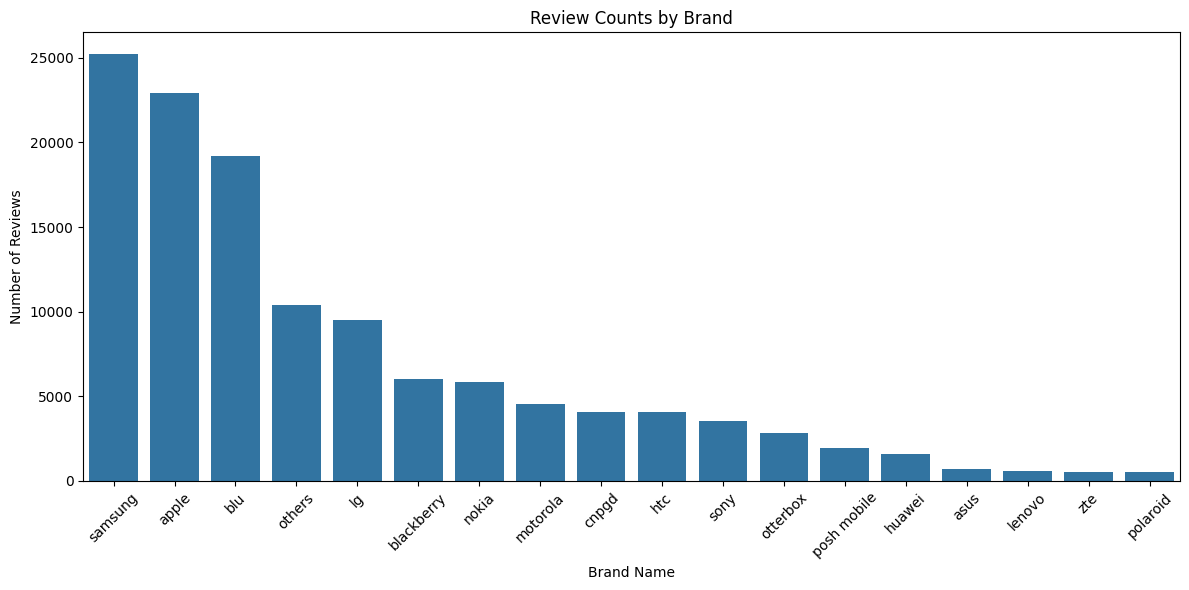

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, x='Brand Name', order=df_final['Brand Name'].value_counts().index)
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')
plt.title('Review Counts by Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rating distribution (brand review > 500)

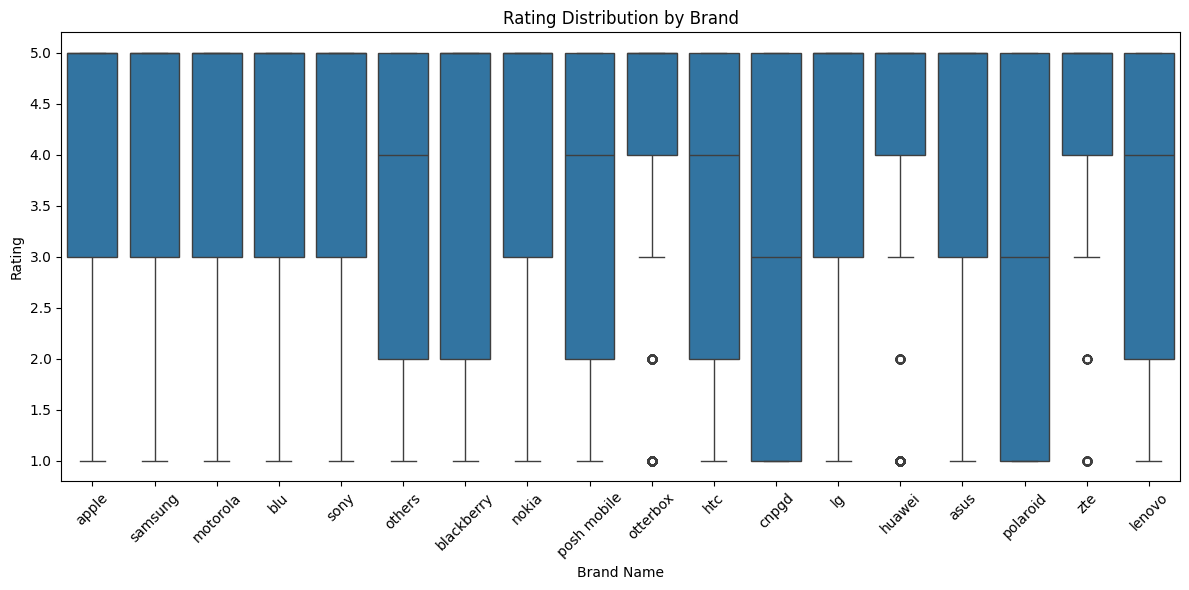

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Brand Name', y='Rating', data=df_final)
plt.xlabel('Brand Name')
plt.ylabel('Rating')
plt.title('Rating Distribution by Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

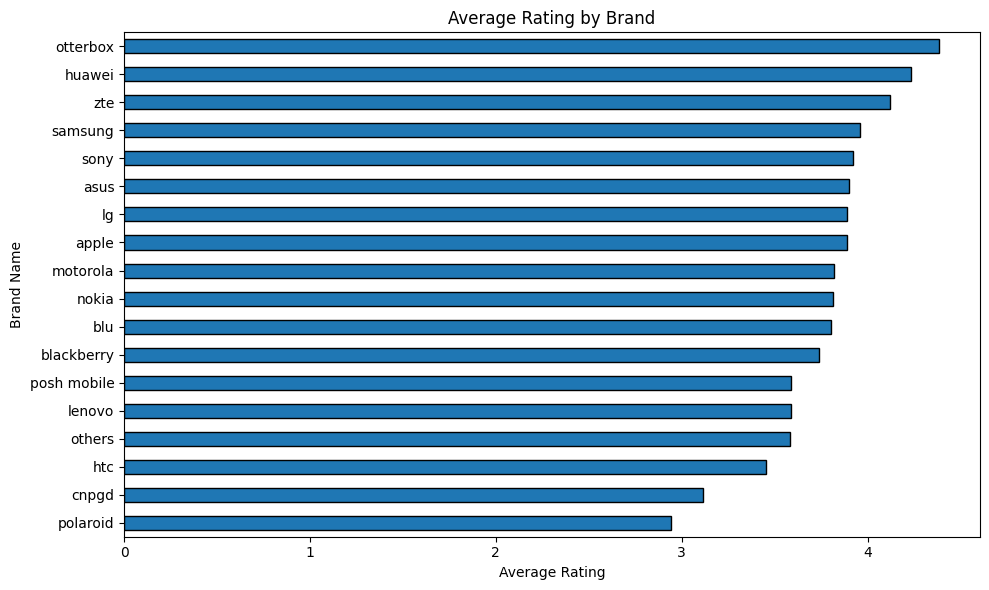

In [18]:
avg_ratings = df_final.groupby('Brand Name')['Rating'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_ratings.plot(kind='barh', edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Brand Name')
plt.title('Average Rating by Brand')
plt.tight_layout()
plt.show()

num of product in each brand

In [19]:
product_counts = df_final.groupby('Brand Name')['Product Name'].nunique().sort_values(ascending=False)
product_counts

Brand Name
others         900
samsung        662
apple          403
blu            303
lg             302
nokia          219
sony           196
htc            192
motorola       188
blackberry     161
huawei         100
posh mobile     52
otterbox        46
lenovo          41
asus            40
zte             32
cnpgd           24
polaroid        11
Name: Product Name, dtype: int64

Same product may categorized into different color, storage, etc. use regularization

In [39]:
def extract_core_product_name(row, brand_col='Brand Name', product_col='Product Name', num_words_fallback=3):
    brand = str(row[brand_col]).lower()
    product = str(row[product_col]).lower() if pd.notna(row[product_col]) else ""

    if not product or product.strip() == "":
        return f"{brand} unknown"

    if 'samsung' in brand:
        match = re.search(r'(galaxy\s(?:s|note|a|z\s?(fold|flip)?|tab)\s?\d{1,2}(?:\s?(ultra|plus)?)?)', product)
        if match:
            return f'samsung {match.group(1).strip()}'
        
    elif 'apple' in brand:
        match = re.search(r'(iphone\s\d{1,2}(?:\s?(?:s|se))?(?:\s?(?:plus|pro|max|pro max))?)', product)
        if match:
            return f'apple {match.group(1).strip()}'
        match = re.search(r'(ipad\s(?:air|pro|mini)?\s?\d?)', product)
        if match:
            return f'apple {match.group(1).strip()}'
        match = re.search(r'(apple\s?watch\s?(series)?\s?\d{1,2})', product)
        if match:
            return f'apple {match.group(1).strip()}'
        
    elif 'sony' in brand:
        match = re.search(r'(xperia\s\w+)', product)
        if match:
            return f'sony {match.group(1).strip()}'

    elif 'lg' in brand:
        match = re.search(r'(lg\s\w+)', product)
        if match:
            return match.group(1).strip()

    elif 'motorola' in brand:
        match = re.search(r'(moto\s\w+)', product)
        if match:
            return f'motorola {match.group(1).strip()}'
    
    elif 'htc' in brand:
        match = re.search(r'(htc\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'blackberry' in brand:
        match = re.search(r'(blackberry\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'nokia' in brand:
        match = re.search(r'(nokia\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'huawei' in brand:
        match = re.search(r'(p\d+|mate\s?\d+)', product)
        if match:
            return f'huawei {match.group(1).strip()}'

    elif 'lenovo' in brand:
        match = re.search(r'(lenovo\s\w+)', product)
        if match:
            return match.group(1).strip()

    elif 'asus' in brand:
        match = re.search(r'(zenfone\s?\w*)', product)
        if match:
            return f'asus {match.group(1).strip()}'

    elif 'zte' in brand:
        match = re.search(r'(zte\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'polaroid' in brand:
        match = re.search(r'(polaroid\s\w+)', product)
        if match:
            return match.group(1).strip()

    elif 'blu' in brand:
        match = re.search(r'(blu\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'cnpgd' in brand:
        match = re.search(r'(cnpgd\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'otterbox' in brand:
        match = re.search(r'(otterbox\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    elif 'posh mobile' in brand or 'posh' in brand:
        match = re.search(r'(posh\s\w+)', product)
        if match:
            return match.group(1).strip()
    
    # fallback for "others" or no-match: 前 num_words_fallback 个词
    return ' '.join(product.split()[:num_words_fallback])

In [40]:
df_final['Product Name'] = df_final.apply(extract_core_product_name, axis=1)

In [41]:
df_final

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,apple iphone 4s,apple,99.99,5,"Gracias, excelente.",0.0
1,samsung galaxy s5,samsung,219.00,1,"I got the phone in good condition, but its car...",2.0
2,apple iphone 5,apple,135.00,5,Great phone No problems works perfect now for ...,1.0
3,motorola moto x,motorola,89.99,5,"great price with the discount, white is a nice...",0.0
4,blu tank,blu,18.93,5,A1,0.0
...,...,...,...,...,...,...
124147,motorola droid 3,motorola,99.99,1,Does not even register as a Verizon phone in t...,2.0
124148,htc droid,htc,29.99,5,this is a prepaid phone and was my first smart...,3.0
124149,samsung galaxy s3,samsung,125.85,5,Excelent,0.0
124150,sony xperia e,sony,189.99,3,"This phone is ok, main issue is it does not ha...",0.0


In [42]:
df_final["Review Votes"].isna().sum()

np.int64(0)

In [43]:
df_final["Review Votes"].fillna(0,inplace=True)
df_final

/var/folders/bd/sjwzf5qj237dq18gq9s2d5b80000gn/T/ipykernel_14371/3875864733.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final["Review Votes"].fillna(0,inplace=True)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,apple iphone 4s,apple,99.99,5,"Gracias, excelente.",0.0
1,samsung galaxy s5,samsung,219.00,1,"I got the phone in good condition, but its car...",2.0
2,apple iphone 5,apple,135.00,5,Great phone No problems works perfect now for ...,1.0
3,motorola moto x,motorola,89.99,5,"great price with the discount, white is a nice...",0.0
4,blu tank,blu,18.93,5,A1,0.0
...,...,...,...,...,...,...
124147,motorola droid 3,motorola,99.99,1,Does not even register as a Verizon phone in t...,2.0
124148,htc droid,htc,29.99,5,this is a prepaid phone and was my first smart...,3.0
124149,samsung galaxy s3,samsung,125.85,5,Excelent,0.0
124150,sony xperia e,sony,189.99,3,"This phone is ok, main issue is it does not ha...",0.0


In [38]:
df_final.to_csv("normalized_amazon_data.csv", index=False)